# Skin Permeability prediction

This notebook presents the methodology and results of generating predictive models for skin permeation using the Huskin skin permeation database. The models developed here are compared favorably to previous attempts at creating predictive models from the same database. For an introduction to this research, please refer to the attached .pdf document. 

## Database Filtering

The data utilized in this study has been carefully filtered from the Huskin database using the following criteria:

- **Used Layer:** Epidermis or Epidermis + Dermis
- **Storage Temperature (Celsius):** ≥ -20°C
- **Neat:** 0 (indicating dilute samples suspended/dissolved in some medium)
- **Storage Duration (Days):** < 50
- **Skin Source Site:** Abdomen


### Rationale for Filters

**Used Layer:**  
Different skin layers exhibit distinct barrier properties. The stratum corneum (SC) serves as the primary barrier to diffusion across the skin, yet it is fragile and difficult to handle in isolation. The epidermis is the smallest layer that includes the SC. Samples comprising both the epidermis and dermis layers are more representative of real-life conditions, as they encompass a greater portion of the diffusive pathway. However, this category has fewer observations. Given that the SC is within the epidermis and serves as the main barrier, the differences in permeation between samples of only the epidermis and those of the epidermis combined with the dermis are likely minimal. Therefore, only samples containing either the epidermis or both the epidermis and dermis were included, excluding samples that solely contain the SC or those with the SC removed.

**Storage Temperature:**  
Literature suggests that storing skin samples at -20°C does not significantly alter the skin's barrier properties (see Waters 2022), whereas storing at -80°C does. Although the exact temperature at which barrier properties begin to diminish is unclear, -20°C was selected as a conservative threshold to ensure integrity.

**Neat Samples:**  
The decision to exclude pure (neat) samples was driven by practicality. The database contains a limited number of pure sample observations (49 entries) compared to non-neat samples (550 entries before filtering). Although the concentration of the permeant can influence permeation, the scarcity of pure sample data precludes a thorough analysis of this dependency.

**Storage Duration:**  
A cutoff of no more than 50 days was implemented based on initial data inspection, which revealed a significant correlation between permeation and storage time. Prolonged storage led to increased minimum permeation, suggesting degradation of the skin barrier over time. The 50-day cutoff retained approximately 80% of the data while effectively removing this correlation.

**Skin Source Site**
It is known that skin sourced from different body parts can have different barrier characteristics. This is thought to mostly be caused by differing skin thicknesses, which can be made uniform by some experimental techniques (dermatoming). Unfortunately, such preparation samples are rare in the Huskin database. As such, only skin permeation data recorded from samples taken from the abdomen were used. The abdomen was selected as this was the largest category. Arguably, skin samples from the hands would be more relevant, as these body parts often undergo more exposure to exogenous compounds.


### Features for Predicting Skin Permeation

The features selected for predicting skin permeation include:

- **logP**
- **Number of heavy atoms in the molecule**
- **Topological polar surface area (TPSA)**
- **Donor temperature**
- **Donor pH**

LogP and TPSA were chosen based on their previously demonstrated strong predictive power for skin permeation. The number of heavy atoms was selected as a proxy for molecular volume, which is known to correlate with skin permeation but typically requires 3D molecular coordinates. Average temperature and pH values were included because, while not filtered, they are known to influence skin barrier properties. Physicochemical properties were calculated using RDkit.


### Handling Missing Data

For observations with missing values, the mean value was imputed. The dataset was split into training and test sets, with mean imputation based on the training set values.



In [1]:
import pandas as pd
import scipy as sp
import numpy as np
from sklearn import linear_model
from matplotlib import pyplot as plt, gridspec

In [2]:
train = pd.read_csv('huskinDB_processed_train_simple.csv')
test = pd.read_csv('huskinDB_processed_test_simple.csv')

print(train.columns)
print(train.shape)
layers = ['epidermis', 'epidermis, dermis']
source_sites = ['abdomen']

train  = train.loc[train['skin source site'].isin(source_sites)]
test = test.loc[test['skin source site'].isin(source_sites)]

train  = train.loc[train['used layer'].isin(layers)]
test = test.loc[test['used layer'].isin(layers)]

x_features = ['logp', 'n_heavy_atoms', 'TPSA', 'donor/skin surface temperature (°C)', 'donor pH',]

x_train = train[x_features]
y_train = train['logkp (cm/s)']

x_test= test[x_features]
y_test= test['logkp (cm/s)']

print(f'train size: {x_train.shape}, test size: {x_test.shape}')

Index(['Compound name', 'Smiles', 'logkp (cm/s)', 'skin donor type',
       'skin source site', 'used layer', 'skin preparation',
       'storage temperature (°C)', 'storage duration (days)', 'neat',
       'donor/skin surface temperature (°C)', 'donor pH', 'donor type',
       'acceptor temperature (°C)', 'acceptor pH', 'acceptor type',
       'cell type', 'flux', 'notes', 'logp', 'n_heavy_atoms', 'TPSA',
       'average temperature', 'average pH'],
      dtype='object')
(139, 24)
train size: (60, 5), test size: (19, 5)


# Analysis

## Generating a Baseline Model

The first step is to create a baseline model against which more complex models can be compared. In this baseline model, the mean $logK_p$ is used to predict $logK_p$, i.e., $y = \text{mean}(logK_p)$. The $R^2$ value will not be calculated, as it will be 0.

In [3]:
from sklearn import metrics

model = np.mean(y_train)

test_rmse, train_rmse = metrics.root_mean_squared_error(y_test, [model for _ in range(len(y_test))]), metrics.root_mean_squared_error(y_train, [model for _ in range(len(y_train))])
test_mae, train_mae = metrics.mean_absolute_percentage_error(y_test, [model for _ in range(len(y_test))]), metrics.mean_absolute_percentage_error(y_train, [model for _ in range(len(y_train))])

print(f'train RMSE: {train_rmse:.3f}, train MAPE: {train_mae:.3f}')
print(f'test RMSE: {test_rmse:.3f}, test MAPE: {test_mae:.3f}')


train RMSE: 1.021, train MAPE: 0.135
test RMSE: 1.030, test MAPE: 0.148


## Linear Regression

With the baseline RMSE performance established, we can now proceed to explore more complex models, starting with a linear regression.


In [4]:
# first a helper function to evaluate model performance is defined:
import matplotlib.gridspec as gridspec
def model_perf(y_train_true, y_train_pred, y_test_true, y_test_pred):
    def model_stats(y_true, y_pred):
        rmse = metrics.root_mean_squared_error(y_true, y_pred)
        mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
        r2 = metrics.r2_score(y_true, y_pred)
        max_error = metrics.max_error(y_true, y_pred)

        stats = {'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'max error': max_error}
        for k, v in stats.items():
            print(f'{k}: {v:.3f}')

        return stats

    print('### Train ###')
    model_stats(y_train_true, y_train_pred)
    print('\n### Test ###')
    model_stats(y_test_true, y_test_pred)

    
    fig = plt.figure(figsize=(8, 8)) 
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_xDist = plt.subplot(gs[0, :2], sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 2], sharey=ax_main)
    
    ax_main.scatter(y_train_true, y_train_pred, label='Train')
    ax_main.scatter(y_test_true, y_test_pred, label='Test', marker='x')
    ax_main.set(xlabel='True logkp / $cm s^{-1}$', ylabel='Predicted logkp / $cm s^{-1}$')
    ax_main.plot([-4, -10], [-4, -10], c='grey', ls='dashed')
    ax_main.legend()
    
    ax_xDist.hist(y_train_true, bins=25)
    ax_xDist.hist(y_test_true, bins=25)

    ax_yDist.hist(y_train_pred, bins=25, orientation='horizontal', align='mid')
    ax_yDist.hist(y_test_pred, bins=25, orientation='horizontal', align='mid')
    
    plt.show() 

### Train ###
RMSE: 0.744
MAPE: 0.097
R2: 0.468
max error: 2.079

### Test ###
RMSE: 0.670
MAPE: 0.085
R2: 0.573
max error: 1.580


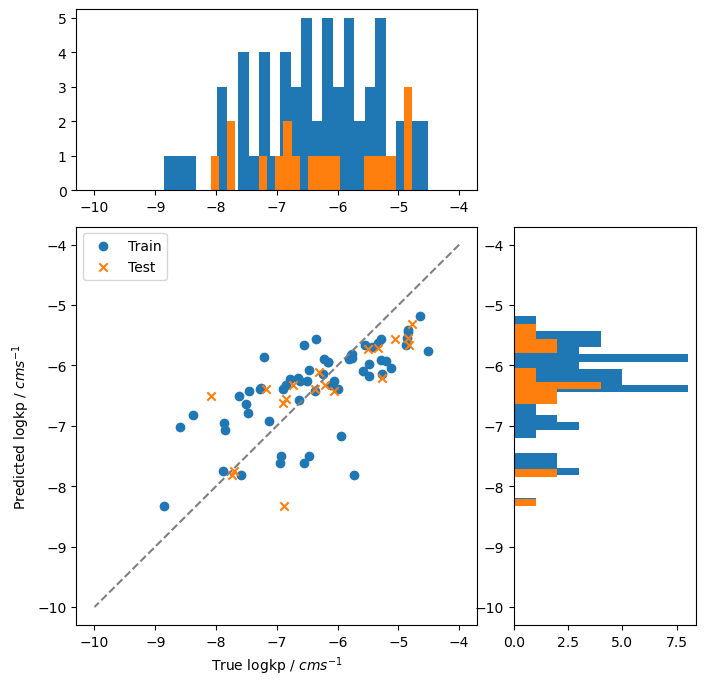

In [5]:
# the model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# model prediction
y_train_pred = regr.predict(x_train)
y_test_pred = regr.predict(x_test)

model_perf(y_train, y_train_pred, y_test, y_test_pred)

Already, the linear model has demonstrated improved performance over the baseline. However, most of the predicted $logK_p$ values are compressed into a narrower range than the true values, indicating that the model has low variance and may not be expressive enough to accurately capture the underlying data patterns.

Before proceeding to train more complex models, it is essential to analyze feature importance to mitigate the risk of overfitting. To achieve this, a Lasso regression model will be fit to the data. Lasso penalizes the L1 norm of the parameter matrix, effectively shrinking some feature coefficients to zero. This method can help identify and eliminate less important features.

One key hyperparameter of the Lasso method is $\alpha$, which controls the strength of the penalty applied to the L1 norm. To determine the optimal $\alpha$ value, multiple 5-fold cross-validation runs will be performed across a range of $\alpha$ values.


## Feature Selection with Lasso

0.0224


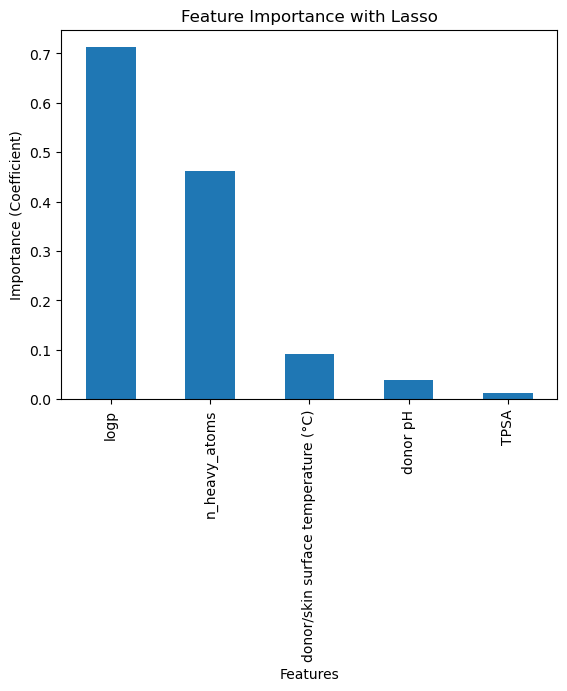

In [6]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5, alphas=np.arange(0.0001, 0.5, 0.0001)).fit(x_train, y_train)
importance = np.abs(lasso.coef_)

print(lasso.alpha_)

feature_importance = pd.Series(importance, index=x_train.columns).sort_values(ascending=False)

# Visualize
feature_importance.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance (Coefficient)')
plt.title('Feature Importance with Lasso')
plt.show()



Lasso regression suggests that **logP** and the **number of heavy atoms** are the most informative features, while **temperature**, **pH**, and **TPSA** exhibit relatively weak predictive power. This finding is of particular interest as, mechanistically, temperature and pH are known to affect the skin barrier, and TPSA has previously been identified as a strong predictor by *Waters et al.* It is important to note that this analysis, along with other feature selection analyses to follow, focuses on identifying linear predictive power. While this approach may be less applicable to more complex models, it still provides valuable insight.

To further explore feature importance, we will now perform a ridge regression analysis, which is a linear regression model with an L2 norm penalty.

## Feature Selection with Ridge


{'alpha_per_target': False, 'alphas': array([1.000e-04, 2.000e-04, 3.000e-04, ..., 4.997e-01, 4.998e-01,
       4.999e-01]), 'cv': 5, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_results': None, 'store_cv_values': 'deprecated'}
0.4999


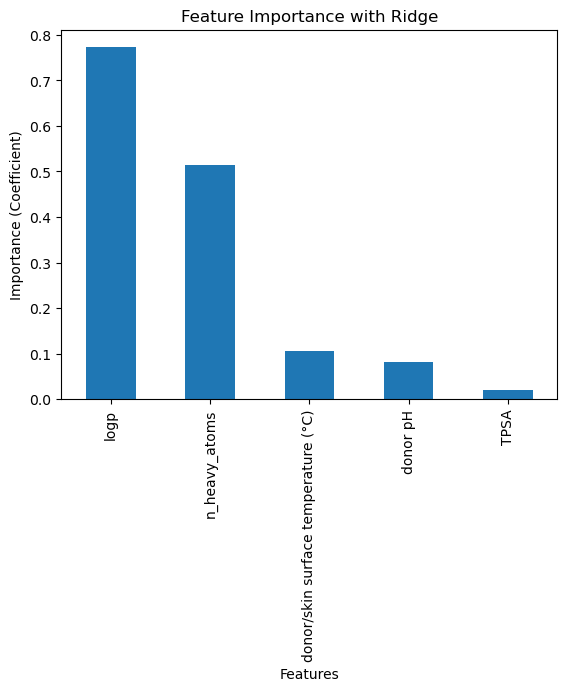

In [7]:
from sklearn.linear_model import RidgeCV

ridge= RidgeCV(cv=5, alphas=np.arange(0.0001, 0.5, 0.0001)).fit(x_train, y_train)
importance = np.abs(ridge.coef_)

print(ridge.get_params())
print(ridge.alpha_)

feature_importance = pd.Series(importance, index=x_train.columns).sort_values(ascending=False)

# Visualize
feature_importance.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance (Coefficient)')
plt.title('Feature Importance with Ridge')
plt.show()


The ridge regression results are broadly consistent with those of the Lasso regression, indicating that each feature contributes some predictive power to the model.

As a final step in our feature analysis, Lasso models will be fit to every possible combination of features. The average coefficients from these models will then be plotted to provide a comprehensive view of feature importance.

## Feature Selection with Lasso for All Feature Combinations


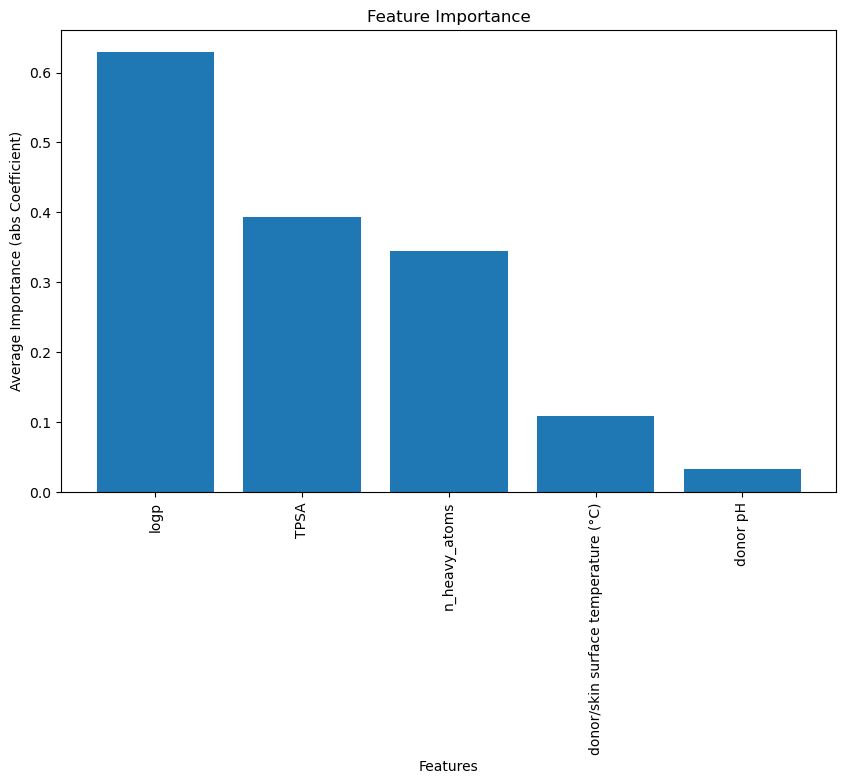

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
from itertools import combinations

def run_regressions(X, y):
    feature_importance = {}
    for k in range(1, X.shape[1] + 1):
        for combo in combinations(range(X.shape[1]), k):
            X_subset = X.iloc[:, list(combo)]
            model = LassoCV().fit(X_subset, y)
            y_pred = model.predict(X_subset)

            r2 = r2_score(y, y_pred)
            mse = mean_squared_error(y, y_pred)
            coefficients = dict(zip(combo, model.coef_))

            for feature, coef in coefficients.items():
                if feature not in feature_importance:
                    feature_importance[feature] = []
                feature_importance[feature].append({
                    'r2': r2,
                    'mse': mse,
                    'coefficient': coef,
                    'model_features': combo
                })

    return feature_importance

# Quantify and visualize feature importance
def summarize_feature_importance(feature_importance):
    summary = []
    for feature, details in feature_importance.items():
        avg_r2 = np.mean([item['r2'] for item in details])
        avg_mse = np.mean([item['mse'] for item in details])
        avg_coef = np.mean([item['coefficient'] for item in details])
        summary.append({
            'feature': feature,
            'avg_r2': avg_r2,
            'avg_mse': avg_mse,
            'avg_coefficient': avg_coef,
            'models_count': len(details)
        })
    return pd.DataFrame(summary)

feature_importance = run_regressions(x_train, y_train)
summary = summarize_feature_importance(feature_importance)

summary.sort_values(by='avg_coefficient', key=abs, ascending=False, inplace=True)
labels = [x_train.columns[i] for i in summary['feature']]
coefficients = summary['avg_coefficient']

plt.figure(figsize=(10, 6))
plt.bar(labels, abs(coefficients))
plt.xlabel('Features')
plt.ylabel('Average Importance (abs Coefficient)')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()



This time, **logP**, **TPSA**, and the **number of heavy atoms** all score highly, suggesting that TPSA has a high covariance with at least one other feature. To explore this further, covariance and correlation matrices are calculated and tabulated below. 

These tables reveal that TPSA has a high covariance with the number of heavy atoms. This explains why the original Lasso model disregarded TPSA; when TPSA was considered in combination with other features, its predictive power became more apparent. When evaluating every feature combination, TPSA re-emerges as an important predictor.

All features will be retained in the model since they each demonstrate some predictive power on a linear scale. Additionally, these features may reveal stronger predictive capabilities when higher-order relationships are accounted for in more complex models.


## Covariance and Correlation Analysis

### Feature Covariance



In [9]:
x_train.cov()

,logp,n_heavy_atoms,TPSA,donor/skin surface temperature (°C),donor pH
logp,0.642314,0.159854,-0.328204,0.141826,0.030640
n_heavy_atoms,0.159854,0.808060,0.597725,0.446319,-0.046227
TPSA,-0.328204,0.597725,0.926017,0.276034,-0.062371
donor/skin surface temperature (°C),0.141826,0.446319,0.276034,0.999625,0.030039
donor pH,0.030640,-0.046227,-0.062371,0.030039,0.565123


### Feature Correlation

In [10]:
x_train.corr()

,logp,n_heavy_atoms,TPSA,donor/skin surface temperature (°C),donor pH
logp,1.000000,0.221885,-0.425560,0.176996,0.050857
n_heavy_atoms,0.221885,1.000000,0.690987,0.496598,-0.068407
TPSA,-0.425560,0.690987,1.000000,0.286903,-0.086219
donor/skin surface temperature (°C),0.176996,0.496598,0.286903,1.000000,0.039967
donor pH,0.050857,-0.068407,-0.086219,0.039967,1.000000


## nth Degree Polynomial Regression

With feature importance quantified and unnecessary features removed, we can now explore more complex models. In this section, a series of nth-order polynomial models will be fitted to the data to capture potential higher-order relationships between features and skin permeation.



polynomial degree: 2
### Train ###
RMSE: 0.648
MAPE: 0.084
R2: 0.597
max error: 1.535

### Test ###
RMSE: 0.536
MAPE: 0.075
R2: 0.727
max error: 1.002


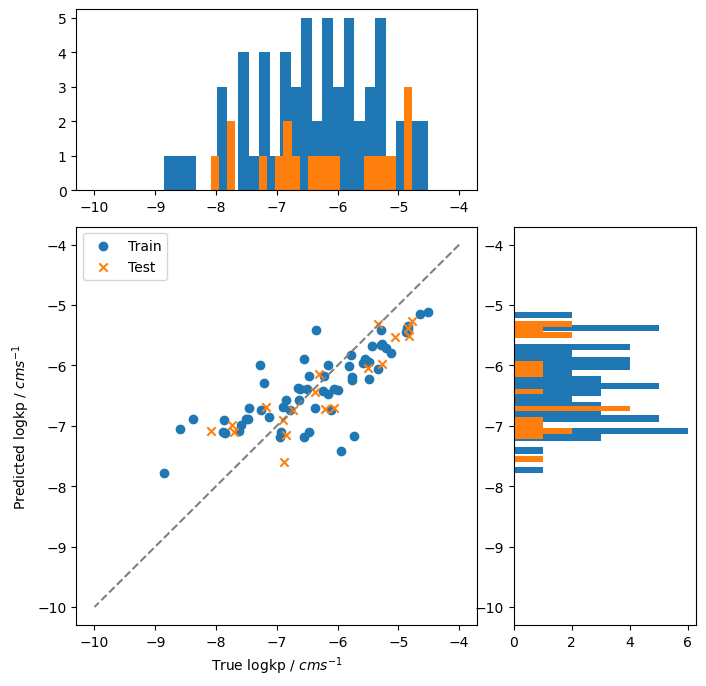

polynomial degree: 3
### Train ###
RMSE: 0.539
MAPE: 0.067
R2: 0.721
max error: 1.315

### Test ###
RMSE: 0.583
MAPE: 0.084
R2: 0.676
max error: 1.069


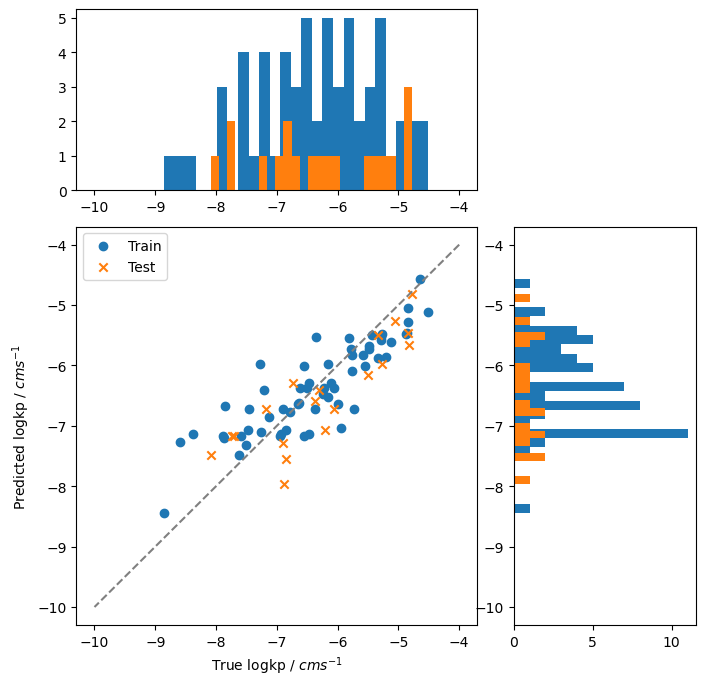

polynomial degree: 4
### Train ###
RMSE: 0.465
MAPE: 0.055
R2: 0.792
max error: 1.276

### Test ###
RMSE: 0.625
MAPE: 0.084
R2: 0.628
max error: 1.407


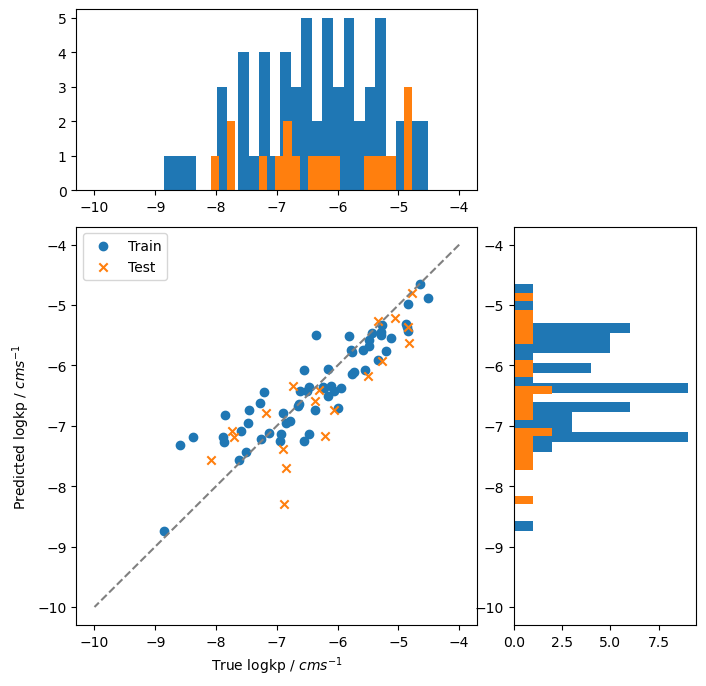

polynomial degree: 5
### Train ###
RMSE: 0.406
MAPE: 0.045
R2: 0.842
max error: 1.144

### Test ###
RMSE: 0.617
MAPE: 0.085
R2: 0.637
max error: 1.306


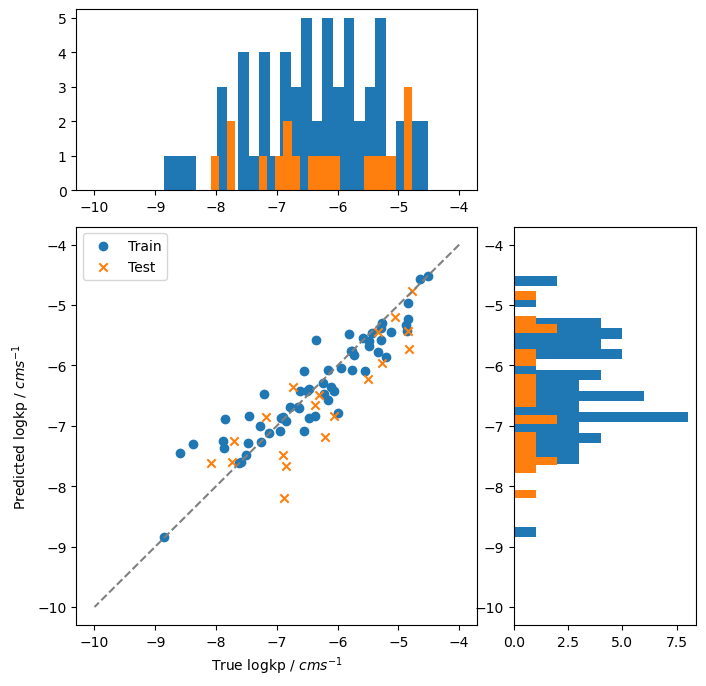

In [11]:
# can we do better with a polynomial model?
from sklearn.preprocessing import PolynomialFeatures

poly_data = {n: PolynomialFeatures(degree=n, include_bias=False) for n in range(2, 6)}

for n in poly_data.keys():
    print(f'polynomial degree: {n}')
    poly = poly_data[n]
    poly_train = poly.fit_transform(x_train)
    poly_test = poly.fit_transform(x_test)
    poly_regr = linear_model.RidgeCV()
    poly_regr.fit(poly_train, y_train)
    y_train_poly_pred = poly_regr.predict(poly_train)
    y_test_poly_pred = poly_regr.predict(poly_test)
    model = model_perf(y_train, y_train_poly_pred, y_test, y_test_poly_pred)
    

The 2nd degree polynomial fit proves to be the most accurate model, with higher-order polynomial models resulting in progressively more overfitting. This is evident from the increasing test set RMSE values and decreasing $R^2$ values as the polynomial order increases. From visual inspection, the 2nd degree polynomial model demonstrates the greatest accuracy for larger (less negative) $logK_p$ values, which is particularly advantageous since these molecules are often of greatest interest in hazard mitigation and the pharmaceutical industry.

Next, we will explore random forest models, followed by XGBoost models. For both approaches, 5-fold cross-validation will be used to determine the optimal max depth and number of trees.

## Random Forest Regression


In [12]:
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()

cvs = {'max_depth': range(3, 10),
       'n_estimators': range(1, 50)}
forest_cv = GridSearchCV(forest, cvs, verbose=1, scoring='neg_mean_squared_error')

forest_cv.fit(x_train, y_train)

Fitting 5 folds for each of 343 candidates, totalling 1715 fits


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(3, 10),
                         'n_estimators': range(1, 50)},
             scoring='neg_mean_squared_error', verbose=1)

{'max_depth': 9, 'n_estimators': 16}
### Train ###
RMSE: 0.340
MAPE: 0.040
R2: 0.889
max error: 0.951

### Test ###
RMSE: 0.496
MAPE: 0.062
R2: 0.765
max error: 0.989


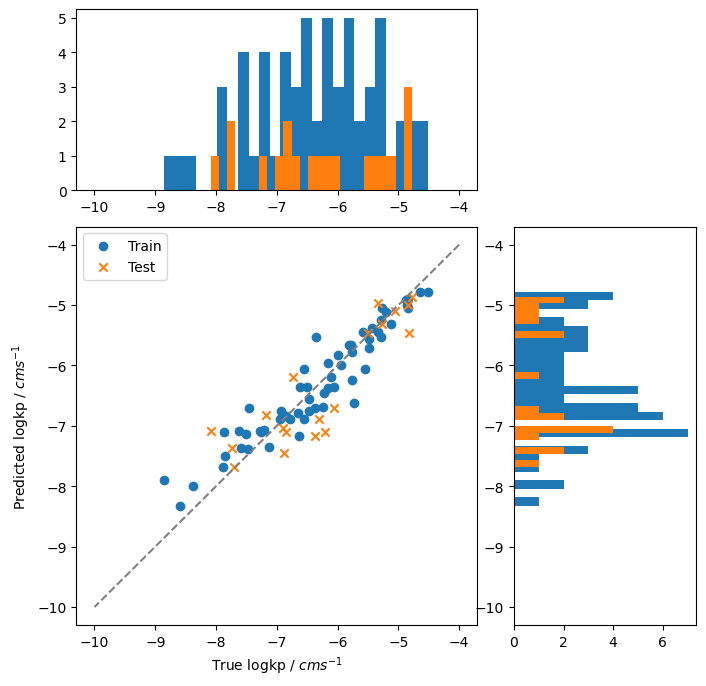

In [13]:
print(forest_cv.best_params_)
y_train_forest_pred = forest_cv.best_estimator_.predict(x_train)
y_test_forest_pred = forest_cv.best_estimator_.predict(x_test)

model_perf(y_train, y_train_forest_pred, y_test, y_test_forest_pred)




## XGBoost Regreesion (Boosted Trees)

In [14]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


gbm = xgb.XGBRegressor(objective='reg:squarederror',
                       booster='dart',
                       rate_drop=0.1,
                       skip_drop=0.5,
                       random_state=0,
                       learning_rate=0.1,
                       device='cpu')


cvs = {'max_depth': range(3, 10),
       'n_estimators': range(1, 50)}
xgb_cv = GridSearchCV(gbm, cvs, verbose=1, scoring='neg_mean_squared_error')
print(type(x_train))

xgb_cv.fit(x_train, y_train)


<class 'pandas.core.frame.DataFrame'>
Fitting 5 folds for each of 343 candidates, totalling 1715 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster='dart',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cpu',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, ...),
             param_grid={'max_depth': range(3, 10),
                         'n_estimators': range(1, 50)},
             scoring='neg_mean_squared_error', verbose=1)

{'max_depth': 3, 'n_estimators': 19}
### Train ###
RMSE: 0.497
MAPE: 0.064
R2: 0.763
max error: 1.282

### Test ###
RMSE: 0.514
MAPE: 0.068
R2: 0.748
max error: 1.011


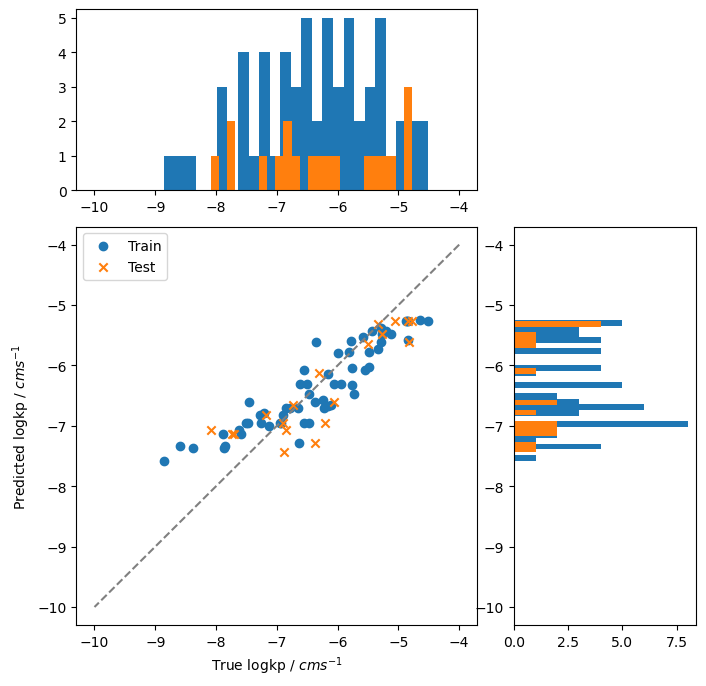

In [15]:
print(xgb_cv.best_params_)
y_train_xgb_pred = xgb_cv.best_estimator_.predict(x_train)
y_test_xgb_pred = xgb_cv.best_estimator_.predict(x_test)

model_perf(y_train, y_train_xgb_pred, y_test, y_test_xgb_pred)

Both Random Forest and XGBoost models outperform the nth degree polynomial models, as shown by lower test set RMSD values and higher $R^2$ values. Interestingly, in this case, Random Forest outperforms XGBoost. Additionally, the two models differ in tree and forest structures, with Random Forest producing fewer, larger trees compared to XGBoost.

Finally, a neural network model will be parameterized. Several network sizes will be considered, with 5-fold cross-validation employed to determine the optimal hyperparameters.

## Neural Network Parameterization

In [16]:
import sklearn.neural_network

mlp = sklearn.neural_network.MLPRegressor(activation='relu',
                                          solver='adam',
                                          max_iter=10000,
                                          learning_rate='adaptive',
                                          learning_rate_init=0.01)

cvs = {'hidden_layer_sizes': [  # different architectures
                              (5,), 
                              (5, 5), 
                              (5, 5, 5),
                              (5, 5, 5, 5),
                              (5, 5, 5, 5, 5),
                              (10,),
                              (10, 10),
                              (10, 10, 10),
                              (10, 10, 10, 10),
                              (20,),
                              (20, 20),
                              (20, 20, 20),
                              (30,),
                              (30, 30)],
       'alpha': np.arange(0.0001, 0.001, 0.00005),  # different l2 loss coefficients
}
        
mlp_cv = GridSearchCV(mlp, cvs, verbose=1, scoring='neg_mean_squared_error', n_jobs=24)
print(type(x_train))

mlp_cv.fit(x_train, y_train)


<class 'pandas.core.frame.DataFrame'>
Fitting 5 folds for each of 252 candidates, totalling 1260 fits


GridSearchCV(estimator=MLPRegressor(learning_rate='adaptive',
                                    learning_rate_init=0.01, max_iter=10000),
             n_jobs=24,
             param_grid={'alpha': array([0.0001 , 0.00015, 0.0002 , 0.00025, 0.0003 , 0.00035, 0.0004 ,
       0.00045, 0.0005 , 0.00055, 0.0006 , 0.00065, 0.0007 , 0.00075,
       0.0008 , 0.00085, 0.0009 , 0.00095]),
                         'hidden_layer_sizes': [(5,), (5, 5), (5, 5, 5),
                                                (5, 5, 5, 5), (5, 5, 5, 5, 5),
                                                (10,), (10, 10), (10, 10, 10),
                                                (10, 10, 10, 10), (20,),
                                                (20, 20), (20, 20, 20), (30,),
                                                (30, 30)]},
             scoring='neg_mean_squared_error', verbose=1)

{'alpha': 0.00045000000000000004, 'hidden_layer_sizes': (5,)}
### Train ###
RMSE: 0.610
MAPE: 0.078
R2: 0.643
max error: 1.479

### Test ###
RMSE: 0.567
MAPE: 0.081
R2: 0.693
max error: 1.123


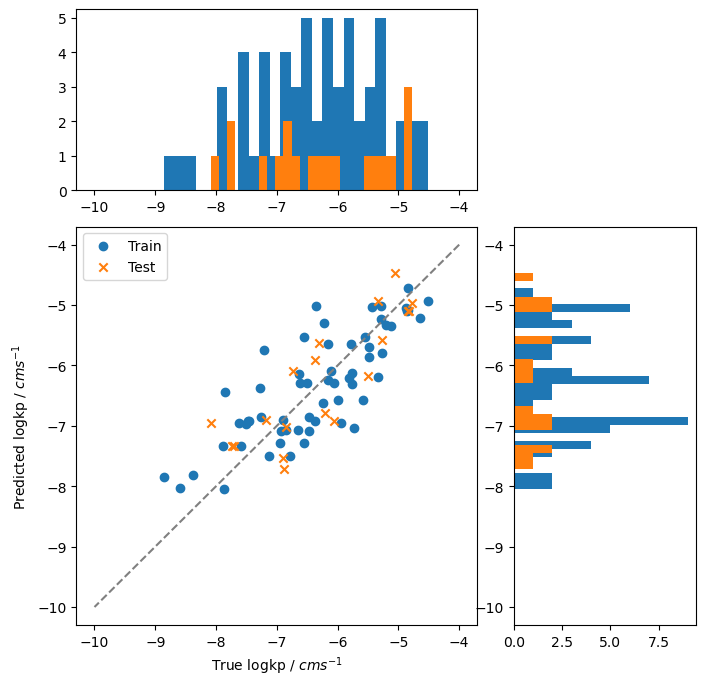

In [17]:
print(mlp_cv.best_params_)
y_train_mlp_pred = mlp_cv.best_estimator_.predict(x_train)
y_test_mlp_pred = mlp_cv.best_estimator_.predict(x_test)

model_perf(y_train, y_train_mlp_pred, y_test, y_test_mlp_pred)


The neural network model has underperformed compared to the Random Forest model, as indicated by larger RMSE values and lower $R^2$ values on the test set. This difference in performance may be attributed to the underlying functional forms of the models. While neural networks rely on functional approximations to capture relationships within the data, Random Forest models uncover underlying 'categories' in the feature space, which are then parameterized additively to generate predictions.


## Concluding Remarks

In this study, several models were developed and fitted to a subset of the Huskin database (n = 79) to predict $logK_p$ using readily available physicochemical molecular properties: (predicted) logP, (predicted) TPSA, number of heavy atoms, and permeation temperature and pH. Notably, when applying these models for evaluation, pH and temperature are not required and can instead be treated as user-defined parameters, provided they remain within reasonable bounds similar to the fitting data. Therefore, mean values of both can be used: temperature ~33°C and pH ~7.4, which are within the biologically relevant range.

The most accurate model created in this work was generated using a random forest, achieving an RMSE of 0.496 and an $R^2$ of 0.765. While this random forest model, along with the other models developed here, is not as accurate as the best model of *Waters et al.* ($R^2$ = 0.8428, RMSE = 0.30), it includes more than double the data (*Waters et al.* n = 36, *this work* n = 79), which likely enhances its generalization capability. Moreover, the models in this work outperform the 'large n' model from *Waters et al.* (n=214, $R^2$ = 0.5057, RMSE = 0.73), representing a middle ground - more generalizable than the small n model of *Waters et al.*, yet more accurate than the large n model. *Waters et al.* also report that the DERMWIN model, used by the U.S. Environmental Protection Agency (EPA), has an $R^2$ of 0.4351 for the Huskin database. Consequently, many of the models developed here surpass the performance of the model currently used by the EPA.

Finally, given that the models presented here are based on various architectures, employing multiple models simultaneously when predicting skin permeability could help mitigate the shortcomings of any single model. Indeed, the models from *Waters et al.* can also be incorporated into this strategy to further diversify predictions and reduce errors stemming from the poor generalization of any individual model, assuming that each model fails in different ways.


## Ethical Considerations

I have decided not to publically release the model parameters for two key reasons:

1. **Need for Rigorous Validation:** The models developed in this study require more thorough validation before they can be applied in health and safety contexts. Ensuring their reliability and accuracy is crucial to avoid potential misuse or misinterpretation in critical applications. Careful consideration as to the chemical similarity between a molecule of interest and molecules used in the training of models selected here are required to contextualise the predicted skin permeation constants. This is knowledge only harnessed by domain experts.

2. **Potential for Misuse:** There is a risk that these models could be exploited for harmful purposes, such as aiding the design of dangerous skin-permeating agents. This concern is not unfounded, as highlighted in the work by Urbina et al. (2022) on the dual use of AI-powered drug discovery for nefarious purposes.

It is important to note that individuals with sufficient knowledge could potentially recreate this work independently. However, such individuals would likely have the capability to generate similar models without accessing this specific research.

For access to models, or discussion about this project, please do feel free to contact me.

[Urbina 2022] F. Urbina, F. Lentzos, C. Invernizzi, and S. Ekins, ‘Dual Use of Artificial Intelligence-powered Drug Discovery’, Nat Mach Intell, vol. 4, no. 3, pp. 189–191, Mar. 2022, doi: 10.1038/s42256-022-00465-9.

